Trees are easy to interpret but often lead to overfitting. XGBoost is used when you don't want to sacrifice the ability to correctly classify observations but also want a model that fits perfectly.

## Important:
XGBoost knows how to handle missing data. The values must be set to 0.

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
import os

In [4]:
os.getcwd()
df=pd.read_csv('Telco_data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.drop(['customerID'],axis=1,inplace=True)

In [6]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


If we want to draw the xgboost tree at the end then we can't have white spaces between names. E.g: electronic check needs to be changes to electronic_check

In [7]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [8]:

df['PaymentMethod']=df['PaymentMethod'].str.replace('(automatic)','',regex=True)
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer ()',
       'Credit card ()'], dtype=object)

In [9]:
for column in df.columns:
    df[column].replace(' ','_',regex=True,inplace=True)
    print(f'Column:{column}, Values: {df[column].unique()}')

Column:gender, Values: ['Female' 'Male']
Column:SeniorCitizen, Values: [0 1]
Column:Partner, Values: ['Yes' 'No']
Column:Dependents, Values: ['No' 'Yes']
Column:tenure, Values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column:PhoneService, Values: ['No' 'Yes']
Column:MultipleLines, Values: ['No_phone_service' 'No' 'Yes']
Column:InternetService, Values: ['DSL' 'Fiber_optic' 'No']
Column:OnlineSecurity, Values: ['No' 'Yes' 'No_internet_service']
Column:OnlineBackup, Values: ['Yes' 'No' 'No_internet_service']
Column:DeviceProtection, Values: ['No' 'Yes' 'No_internet_service']
Column:TechSupport, Values: ['No' 'Yes' 'No_internet_service']
Column:StreamingTV, Values: ['No' 'Yes' 'No_internet_service']
Column:StreamingMovies, Values: ['No' 'Yes' 'No_internet_service']
Column:Contract, Values: ['Month-to-month' 'O

In [10]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

We see that TotalCharges is labelled as an object whereas it just has numbers. So, it's possible that it has numbers and characters. But printing unique values doesn't help much because there are so many of them

In [11]:
len(df.loc[df['TotalCharges']=='_'])

11

There are 11 rows with No total charges mentioned

In [12]:
df.loc[df['TotalCharges']=='_']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(),52.55,_,No
753,Male,0,No,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,_,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,_,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,_,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(),56.05,_,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,_,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,_,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,_,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,_,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,_,No


In [13]:
df.loc[(df['TotalCharges']=='_'),'TotalCharges']=0
# Here we set the TotalCharges column to 0 only for cases where TotalCharges were _


In [14]:
df.loc[df['tenure']==0]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,No,Yes,Yes,Yes,No,Two_year,Yes,Bank_transfer_(),52.55,0,No
753,Male,0,No,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.25,0,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two_year,No,Mailed_check,80.85,0,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.75,0,No
1340,Female,0,Yes,Yes,0,No,No_phone_service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two_year,No,Credit_card_(),56.05,0,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,19.85,0,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,25.35,0,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,No,Mailed_check,20.00,0,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,No_internet_service,One_year,Yes,Mailed_check,19.70,0,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two_year,No,Mailed_check,73.35,0,No


XGBoost only allows int, float or boolean data types so we conver TotalCharges to numeric

In [15]:
df['TotalCharges']=pd.to_numeric(df['TotalCharges'])
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [16]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


# Data Vizualization

- Checking the distribution of yes and no in Churn

Text(0, 0.5, 'proportion of values')

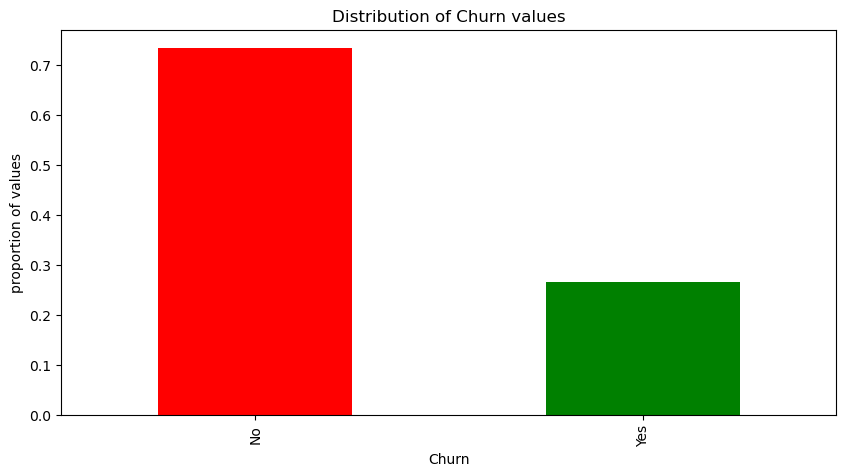

In [17]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot()

response=df['Churn'].value_counts(normalize=True)

response.plot(kind='bar',ax=ax,color=['red','green'])

ax.set_title('Distribution of Churn values')
ax.set_xlabel('Churn')
ax.set_ylabel('proportion of values')

- Assessing the influence of each independent catagorical variable on outcome

Here, normalized stacked bar is used. It makes each column the same height so it's not useful while comparing total numbers but useful for comparing how response variable varies across all groups of independent variable.

Histograms are used to evaluate influence of each independent numeric variable in the outcome. Since, the dataset is imbalanced (seen above), probability density function of each class must be drawn to compare with distributions.

In [18]:
import math
def per_stacked_plot(cols_to_plot,title):
    '''Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    title (string): Super title of the visualization
            Returns:
                    None
    '''

    num_cols=2
    num_rows=math.ceil(len(cols_to_plot)/2)
    
    fig=plt.figure(figsize=(12,5*num_rows))
    fig.suptitle(title)

    # Looping through each column name to create subplot

    for index,column in enumerate(cols_to_plot,1):

        ax=fig.add_subplot(num_rows,num_cols,index)

        # Calculating % of observations of response variable for each group of independent variable

        proportion_independent=pd.crosstab(df[column], df['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        proportion_independent.plot(kind='bar',color=['springgreen','salmon'],ax=ax,stacked=True)

        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        ax.tick_params(rotation='auto')
        ax.set_title('Proportion of observations by ' + column,fontsize=11,loc='left')

        
        


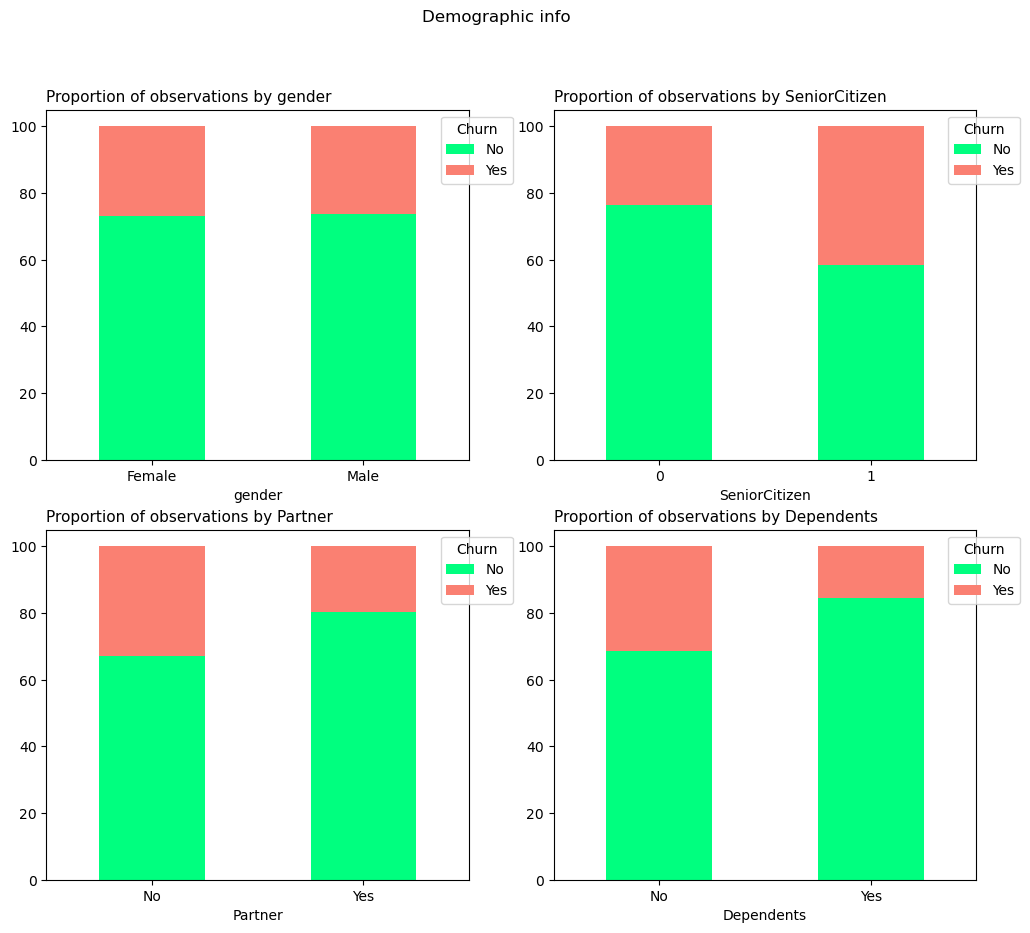

In [19]:
demographic_cols=['gender','SeniorCitizen','Partner','Dependents']

per_stacked_plot(demographic_cols,'Demographic info')

Conclusions from above graphs:
- Gender doesn't have significant predictive power as similar churn is shown for both
- Churn rate of people with no partner is higher than ones with partner
- Senior citizens churn at almost double the rate of young

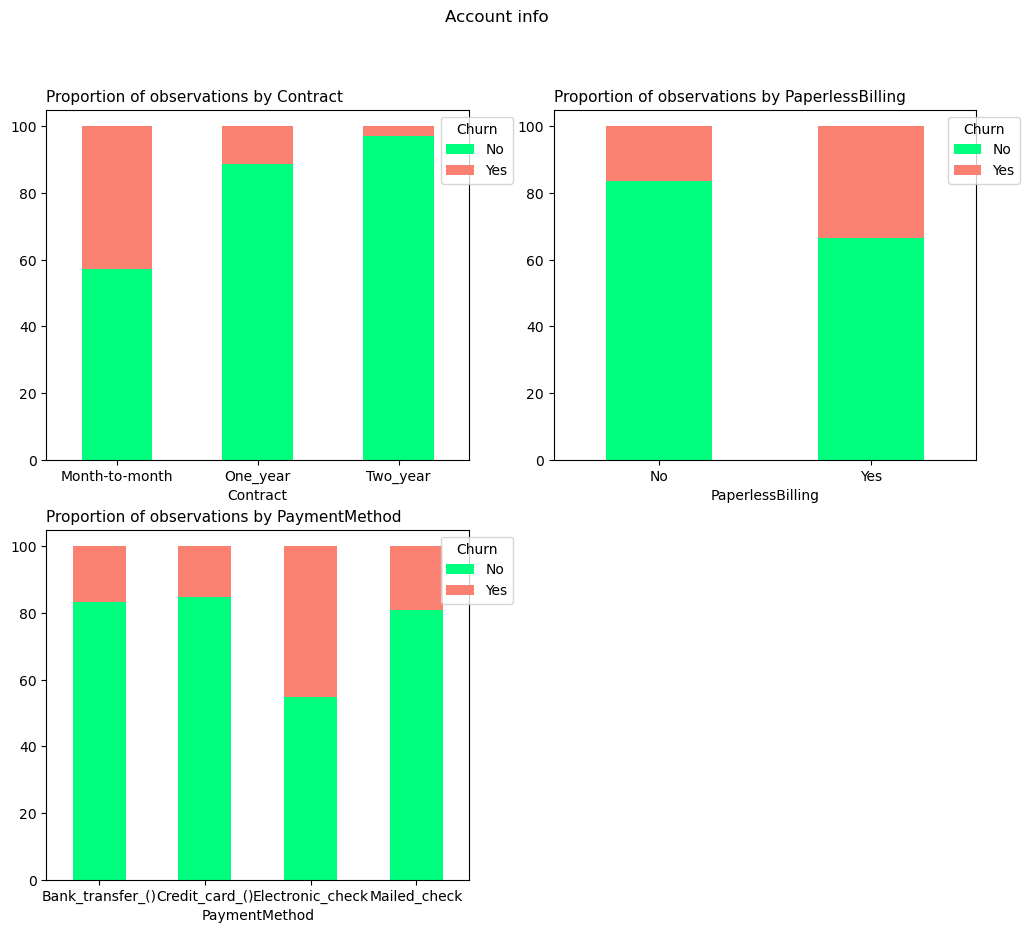

In [20]:
# Now, evaluate the percentage of churn for account information attributes
account_cols=['Contract','PaperlessBilling','PaymentMethod']
per_stacked_plot(account_cols,'Account info')

Conclusions from above graphs:
- Customers with paperless billing churn more
- Customers with electronic check as payment method churn more
- Month-to-month contract customers churn more

In [21]:
# Now plot the customer account info for numerical values
# For this, the tenure, Monthlycharges and TotalCharges distributions are plot

def hist_plots(cols_list,title):
    '''
    Prints a histogram for each independent variable of the list columns_to_plot.
            Parameters:
                    cols_list: Names of the variables to plot
                    title(string): Super title of the visualization
            Returns:
                    None
    '''

    num_cols=2
    num_rows=math.ceil(len(cols_list)/2)

    fig=plt.figure(figsize=(12,5*num_rows))
    fig.suptitle(title)

    for index,column in enumerate(cols_list,1):

        ax=fig.add_subplot(num_rows,num_cols,index)

        df[df['Churn']=='No'][column].plot(kind='hist',ax=ax,density=True,color='springgreen',label='No',alpha=0.5)

        df[df['Churn']=='Yes'][column].plot(kind='hist',ax=ax,density=True,color='salmon',label='Yes',alpha=0.5)

        ax.legend(loc='upper right',title='Churn')

        ax.set_title('Distribution of '+ column + ' by churn')

        


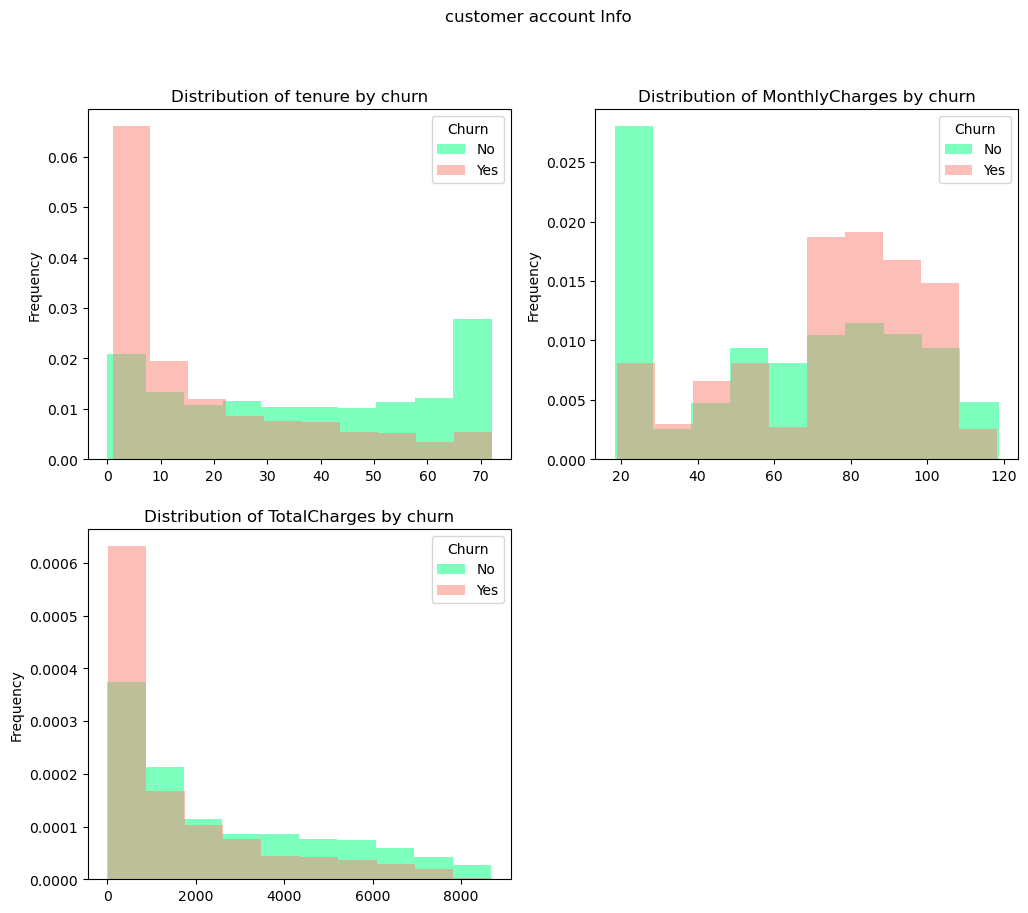

In [22]:
df.columns
numerical_account_info=['tenure','MonthlyCharges','TotalCharges']

hist_plots(numerical_account_info,'customer account Info')

Conclusions from above plots:
- High churn rate for less tenure customers i.e new customers
- High churn rates when monghtly charges are high

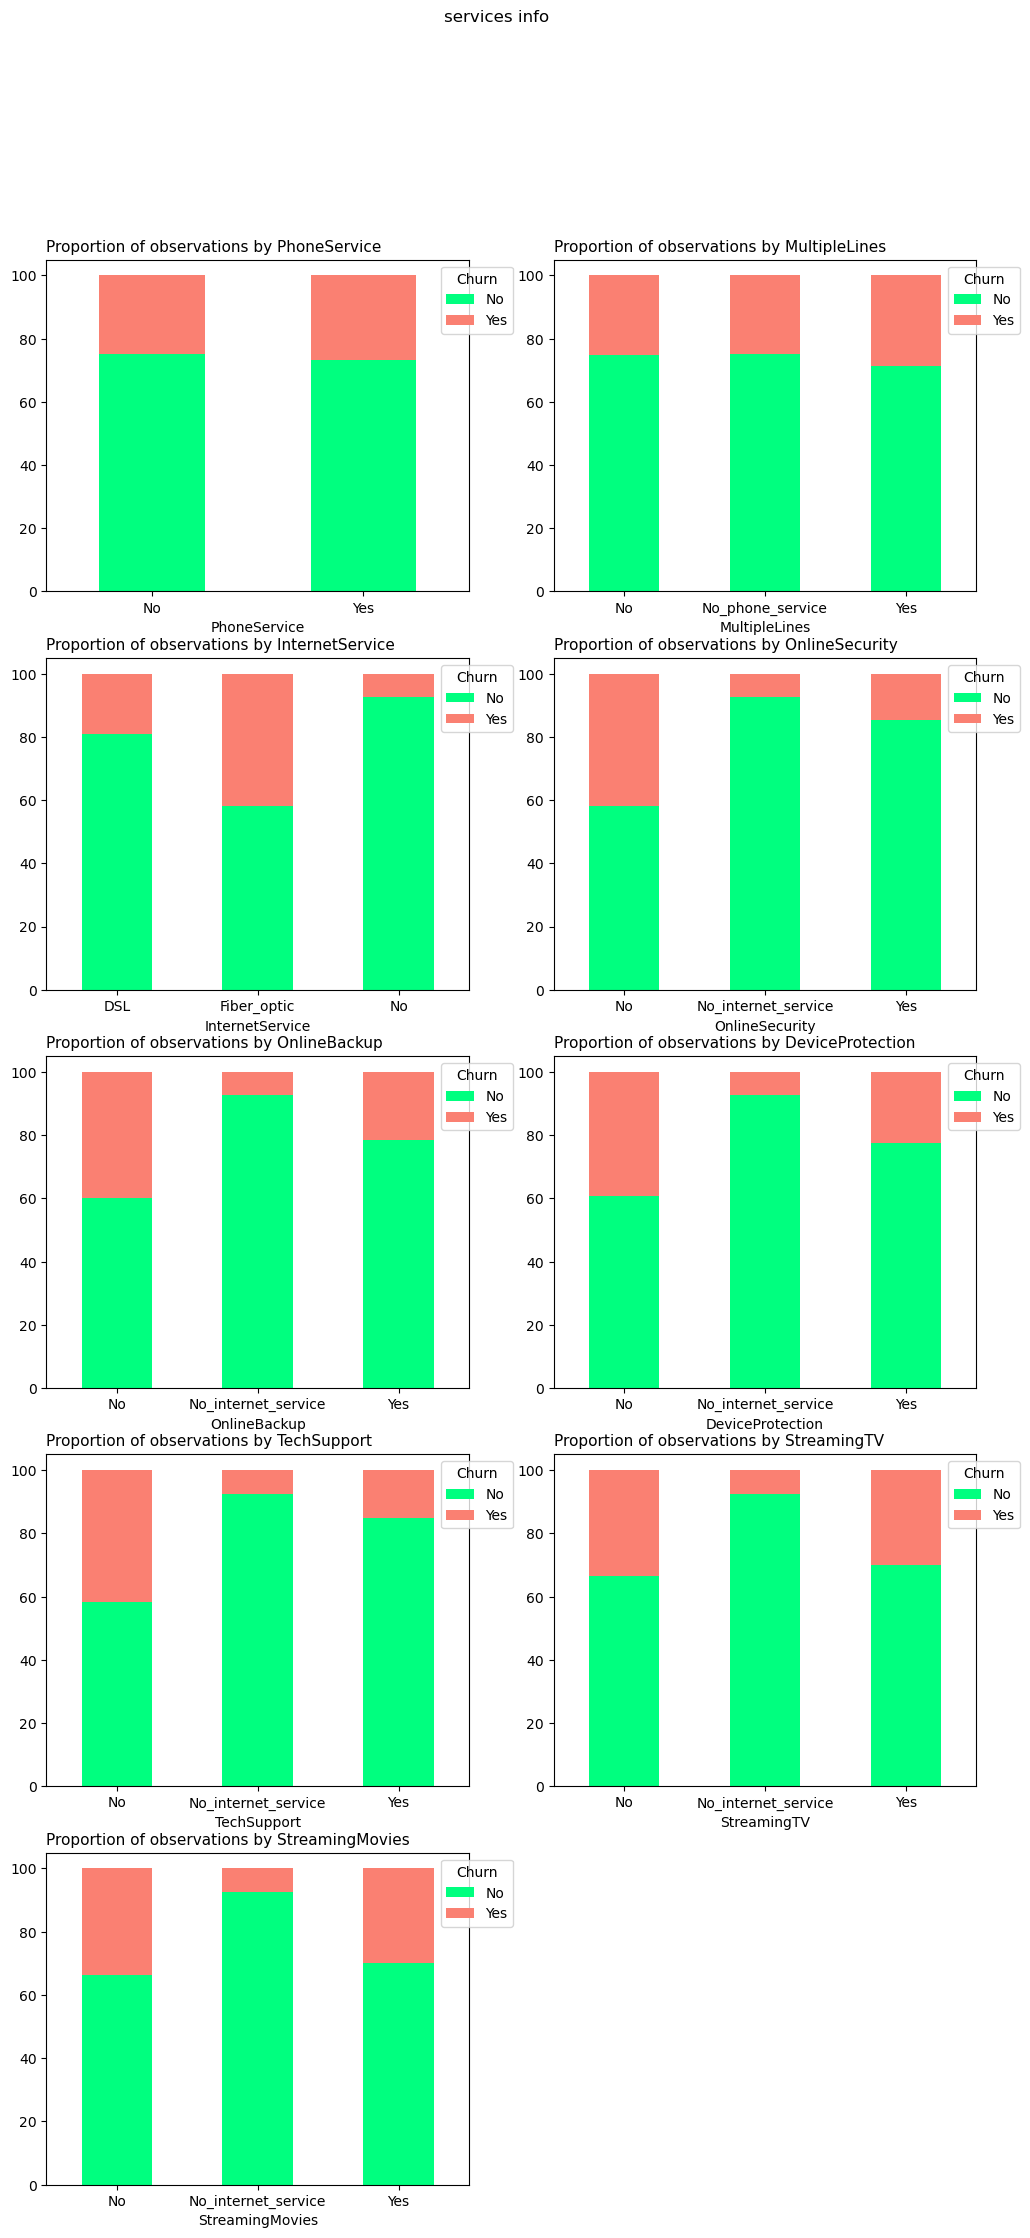

In [23]:
# Now plotting the Services columns to visualize how they impact the churn

services_cols=['PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
per_stacked_plot(services_cols,'services info')

Conclusions from above plot:
- PhoneServices and MultipleLines have no significant predictive power

All the above vizualizations help us determine which attributes are most relevant in predicting churn


# Feature importance
Mutual information measures the mutual dependency between two variables based on entropy estimations. In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the response variable.

Scikit-learn ahs a mutual_info_score that computes mututal information score between each categorical variable of dataset and churn. This also helps determine the most relevant attributes

In [24]:
from sklearn.metrics import mutual_info_score

def get_mutual_info(categorical_series):
    return mutual_info_score(categorical_series,df['Churn'])

categ_series=df.select_dtypes(include=object).drop('Churn',axis=1)
feature_importance=categ_series.apply(get_mutual_info).sort_values(ascending=False)
print(feature_importance)

Contract            0.098453
OnlineSecurity      0.064677
TechSupport         0.063021
InternetService     0.055574
OnlineBackup        0.046792
PaymentMethod       0.044519
DeviceProtection    0.043917
StreamingMovies     0.032001
StreamingTV         0.031908
PaperlessBilling    0.019194
Dependents          0.014467
Partner             0.011454
MultipleLines       0.000801
PhoneService        0.000072
gender              0.000037
dtype: float64


<Axes: >

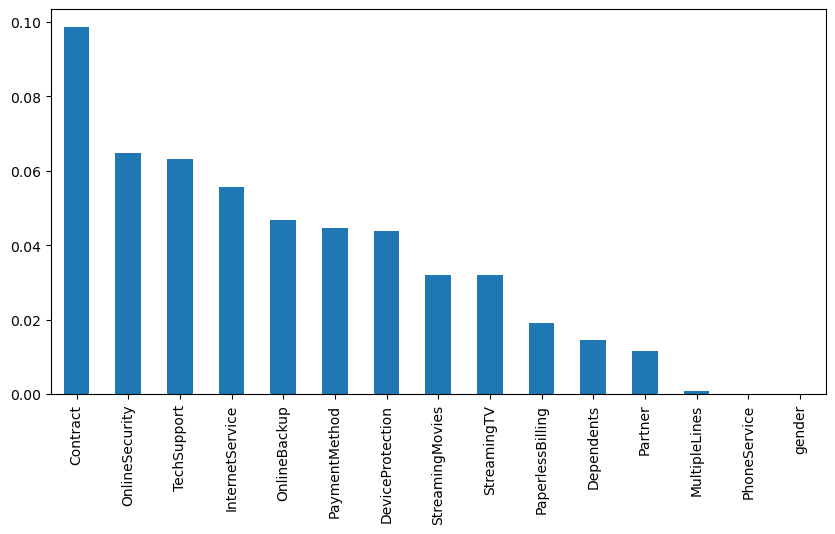

In [25]:
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot()
feature_importance.plot(kind='bar')

# Feature Engineering

Most ML models need data to be in numeric values. So, all categorical attributes should be labelled into numerical labels. Also, cols with numeric values need to be scaled to a common scale (e.g using normalization). This will prevent that the columns with large values dominate the learning process.

In [26]:
for col in df.columns:
    print(f'{col}: {df[col].unique()}')

# Performing label encoding for binary labels

df_transformed=df.copy()
label_enc_cols=['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn']

for col in label_enc_cols:
    if col=='gender':
        df_transformed[col]=df[col].map({'Female':1,'Male':0})
    else:
        df_transformed[col]=df[col].map({'Yes':1,'No':0})

df_transformed.head()

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService: ['No' 'Yes']
MultipleLines: ['No_phone_service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber_optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No_internet_service']
OnlineBackup: ['Yes' 'No' 'No_internet_service']
DeviceProtection: ['No' 'Yes' 'No_internet_service']
TechSupport: ['No' 'Yes' 'No_internet_service']
StreamingTV: ['No' 'Yes' 'No_internet_service']
StreamingMovies: ['No' 'Yes' 'No_internet_service']
Contract: ['Month-to-month' 'One_year' 'Two_year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic_check' 'Mailed_check' 'Bank_transfer_()' 'Credit_card_()']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,1,0,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic_check,29.85,29.85,0
1,0,0,0,0,34,1,No,DSL,Yes,No,Yes,No,No,No,One_year,0,Mailed_check,56.95,1889.50,0
2,0,0,0,0,2,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed_check,53.85,108.15,1
3,0,0,0,0,45,0,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,0,Bank_transfer_(),42.30,1840.75,0
4,1,0,0,0,2,1,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,1,Electronic_check,70.70,151.65,1


# One hot encoding

This is applied to categorical variables for easy interpretation of values

In [27]:
df_transformed.columns
one_hot_cols=['MultipleLines','InternetService', 'OnlineSecurity','Contract','PaymentMethod', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies']
df_transformed=pd.get_dummies(df_transformed,columns=one_hot_cols,dtype=int)


In [28]:
df_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes
0,1,0,1,0,1,0,1,29.85,29.85,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,34,1,0,56.95,1889.50,0,...,1,1,0,0,1,0,0,1,0,0
2,0,0,0,0,2,1,1,53.85,108.15,1,...,0,1,0,0,1,0,0,1,0,0
3,0,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,1,1,0,0,1,0,0
4,1,0,0,0,2,1,1,70.70,151.65,1,...,0,1,0,0,1,0,0,1,0,0


# Data Normalization
This is used to transform numeric columns to a common scale. After normalization, all variables have similar influence on model.

Here, I used the min-max approach to normalize and rescale numneric columns (tenure, MonthlyCharges and TotalCharges)
The min-max approach rescales feature to a fixed range of [0,1] by subtracting the minimum value of feature and dividing by the range 

In [29]:
num_cols=['tenure','MonthlyCharges','TotalCharges']

for col in num_cols:

    min_val=df_transformed[col].min()
    max_val=df_transformed[col].max()

    df_transformed[col]=(df_transformed[col]-min_val)/(max_val-min_val)

# Splitting the data into training and testing

In [30]:
df_transformed.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes
0,1,0,1,0,0.013889,0,1,0.115423,0.003437,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0.472222,1,0,0.385075,0.217564,0,...,1,1,0,0,1,0,0,1,0,0
2,0,0,0,0,0.027778,1,1,0.354229,0.012453,1,...,0,1,0,0,1,0,0,1,0,0
3,0,0,0,0,0.625000,0,0,0.239303,0.211951,0,...,1,0,0,1,1,0,0,1,0,0
4,1,0,0,0,0.027778,1,1,0.521891,0.017462,1,...,0,1,0,0,1,0,0,1,0,0


In [31]:
X=df_transformed.drop('Churn',axis=1).copy()
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,DeviceProtection_Yes,TechSupport_No,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No_internet_service,StreamingMovies_Yes
0,1,0,1,0,0.013889,0,1,0.115423,0.003437,0,...,0,1,0,0,1,0,0,1,0,0
1,0,0,0,0,0.472222,1,0,0.385075,0.217564,1,...,1,1,0,0,1,0,0,1,0,0
2,0,0,0,0,0.027778,1,1,0.354229,0.012453,1,...,0,1,0,0,1,0,0,1,0,0
3,0,0,0,0,0.625000,0,0,0.239303,0.211951,0,...,1,0,0,1,1,0,0,1,0,0
4,1,0,0,0,0.027778,1,1,0.521891,0.017462,1,...,0,1,0,0,1,0,0,1,0,0


In [32]:
y=df_transformed['Churn'].copy()
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [33]:
y.unique()

array([0, 1], dtype=int64)

In [34]:
print(sum(y)/len(y))
'''This shows that dataset is imbalanced. The ratio of people who left the company is just 0.26. So while splitting the data we use stratification in the train_test_split function to maintain the same
percentage of people who left in both training and testing set (27%)'''

0.2653698707936959


'This shows that dataset is imbalanced. The ratio of people who left the company is just 0.26. So while splitting the data we use stratification in the train_test_split function to maintain the same\npercentage of people who left in both training and testing set (27%)'

In [35]:
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=42)

In [36]:
# To ensure the data is split in the correct ratio by stratify
sum(y_train)/len(y_train)
sum(y_test)/len(y_test)

0.26519023282226006

In [37]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',missing=0,seed=42,early_stopping_rounds=10,eval_metric='aucpr')
clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])
'''early stopping is for when the point is encountered where prediction doesn't improve further. So then XGBoost will build 10 more trees,
If in all those 10 trees, nono of them improves on prediction, then it will stop'''
'''I passed the eval_set to validate on testing data'''

[0]	validation_0-aucpr:0.64082
[1]	validation_0-aucpr:0.63926
[2]	validation_0-aucpr:0.63573
[3]	validation_0-aucpr:0.64525
[4]	validation_0-aucpr:0.64718
[5]	validation_0-aucpr:0.64256
[6]	validation_0-aucpr:0.64265
[7]	validation_0-aucpr:0.64031
[8]	validation_0-aucpr:0.63858
[9]	validation_0-aucpr:0.64437
[10]	validation_0-aucpr:0.64469
[11]	validation_0-aucpr:0.64261
[12]	validation_0-aucpr:0.64333
[13]	validation_0-aucpr:0.64279


'I passed the eval_set to validate on testing data'

In [38]:
y_pred=clf_xgb.predict(X_test)

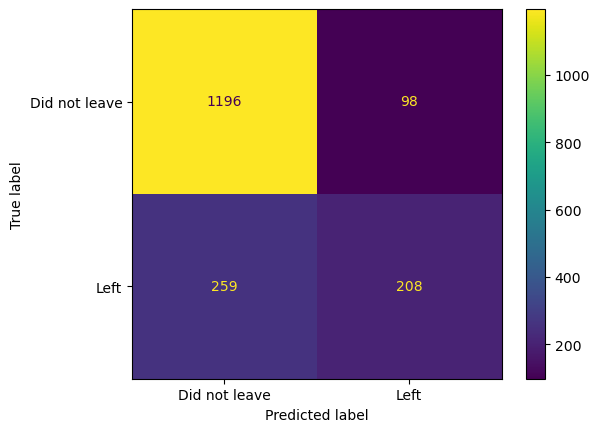

In [39]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm,display_labels=['Did not leave','Left'])
disp.plot()

From above, we see that out of 1294 (1196+98) people that did not leave, 1196 (92%) were correctly classified. Out of the 467 people that left, only 44.5% were correctly classified. Thus, XGBoost did not perform well. Mainly because the data is imbalanced. because people leaving costs the company a lot of money, I tried to capture more of people that left. XGBoost has a parameter (scale_pos_weight) that helps with imbalanced data. Now, I tried to improve using Cross Validation and GridSearch.

The scale_pos_weight adds a penalty for incorrectly classifying the minority class. Here 'the people that left company' is minority class and I wanted to increase the penalty so trees try harder to correctly classify them.

## Parameters in XGBoost

XGBoost has a lot of params that have to be manually configured. E.g: max_depth, learning_rate, gamma (encourages pruning), regularization param. I used GridSearchCV() to test multiple combinations of parameters.
In order to optimize parametrs in a short period of time, I ran GridSearchCV in 2 separate rounds to get the best params.

To speed up cross validation and to further prevent overfitting, only 90% of data was used and only 50% of random subset of features were used per tree.

In [40]:
# Round 1

params_r1={'max_depth':[3,4,5],'gamma':[0,0.25,1.0],'learning_rate':[0.1,0.01,0.05],'reg_lambda':[0,1.0,10.0],'scale_pos_weight':[1,3,5]}

optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',seed=42,subsample=0.9,colsample_bytree=0.5),param_grid=params_r1,scoring='roc_auc',verbose=0,n_jobs=10,cv=3)
'''TO speed up cv, only a random subset of data (90%) is selected, this also prevents overfitting
And only a random subset of features i.e columns are selected (50%) '''

'TO speed up cv, only a random subset of data (90%) is selected, this also prevents overfitting\nAnd only a random subset of features i.e columns are selected (50%) '

In [41]:
optimal_params.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='auc',eval_set=[(X_test,y_test)],verbose=False)


c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [0, 0.25, 1.0],
                         'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'reg_lambda': [0, 1.0, 10.0],
                         'scale_pos_weight': [1, 3, 5]},
             scoring='roc_auc')

In [42]:
optimal_params.best_params_
# optimal_params.best_score_

{'gamma': 1.0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'reg_lambda': 10.0,
 'scale_pos_weight': 3}

In [43]:
'''Upon observing the best params, max_depth of 3 suggests that we should also try lower max-depth, learning rate of 0.05 suggests that
we can try for higher learning rates and same for scale_pos_weight'''
params_r2={'max_depth':[1,2,3],'learning_rate':[0.1,0.5,1],'reg_lambda':[10.0,20.0,100.0],'gamma':[1.25,1.5,1.75]}
final_opt_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',seed=42,subsample=0.9,colsample_bytree=0.5),param_grid=params_r2,
                              scoring='roc_auc',verbose=2,n_jobs=10,cv=3)


In [44]:
final_opt_params.fit(X_train,y_train,early_stopping_rounds=10,eval_metric='auc',eval_set=[(X_test,y_test)],verbose=False)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=10,
             param_grid={'gamma': [1.25, 1.5, 1.75],
                         'learning_rate': [0.1, 0.5, 1], 'max_depth': [1, 2, 3],
                         'reg_lambda': [10.0, 20.0, 100.0]},
             scoring='roc_auc', verbose=2)

In [45]:
final_opt_params.best_params_
# final_opt_params.best_score_


{'gamma': 1.25, 'learning_rate': 0.5, 'max_depth': 2, 'reg_lambda': 20.0}

Having found the best parameters, I retrained the xgb classifier with the best parameters

In [46]:
# from sklearn.metrics import accuracy_score
# acc=accuracy_score(y_test,y_pred)
# print(acc)

In [47]:
clf_xgb=xgb.XGBClassifier(seed=42,objective='binary:logistic',gamma=1.25,learn_rate=0.5,max_depth=2,reg_lambda=20.0,scale_pos_weight=3,subsample=0.9,
                          col_sample_bytree=0.5,early_stopping_rounds=10,eval_metric='aucpr')

clf_xgb.fit(X_train,y_train,verbose=True,eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.49935
[1]	validation_0-aucpr:0.52546
[2]	validation_0-aucpr:0.57883
[3]	validation_0-aucpr:0.59500
[4]	validation_0-aucpr:0.60662
[5]	validation_0-aucpr:0.60853
[6]	validation_0-aucpr:0.61407
[7]	validation_0-aucpr:0.61939


c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\xgboost\core.py:160: UserWarning: [20:13:28] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "col_sample_bytree", "learn_rate" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-aucpr:0.63932
[9]	validation_0-aucpr:0.64347
[10]	validation_0-aucpr:0.64409
[11]	validation_0-aucpr:0.64487
[12]	validation_0-aucpr:0.64707
[13]	validation_0-aucpr:0.64667
[14]	validation_0-aucpr:0.64797
[15]	validation_0-aucpr:0.64917
[16]	validation_0-aucpr:0.64853
[17]	validation_0-aucpr:0.65119
[18]	validation_0-aucpr:0.65101
[19]	validation_0-aucpr:0.65178
[20]	validation_0-aucpr:0.65255
[21]	validation_0-aucpr:0.65264
[22]	validation_0-aucpr:0.65150
[23]	validation_0-aucpr:0.65283
[24]	validation_0-aucpr:0.65353
[25]	validation_0-aucpr:0.65303
[26]	validation_0-aucpr:0.65294
[27]	validation_0-aucpr:0.65265
[28]	validation_0-aucpr:0.65470
[29]	validation_0-aucpr:0.65466
[30]	validation_0-aucpr:0.64989
[31]	validation_0-aucpr:0.64945
[32]	validation_0-aucpr:0.65104
[33]	validation_0-aucpr:0.65252
[34]	validation_0-aucpr:0.65242
[35]	validation_0-aucpr:0.65226
[36]	validation_0-aucpr:0.65110
[37]	validation_0-aucpr:0.65021


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_bytree=0.5, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric='aucpr', feature_types=None, gamma=1.25,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learn_rate=0.5, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [48]:
y_pred=clf_xgb.predict(X_test)

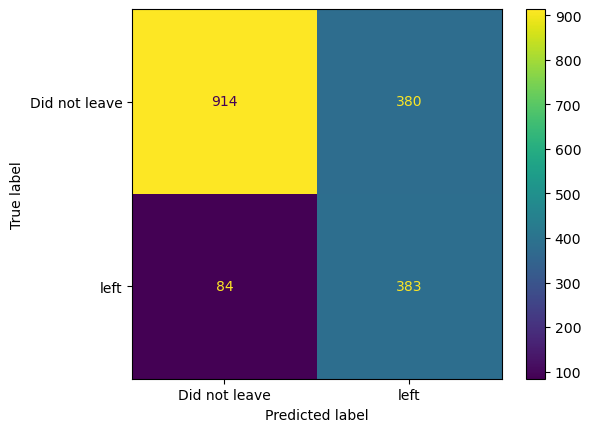

In [49]:
cm=confusion_matrix(y_test,y_pred)
disp=ConfusionMatrixDisplay(cm,display_labels=['Did not leave','left'])
disp.plot()

In [50]:
# from sklearn.metrics import accuracy_score
# acc=accuracy_score(y_test,y_pred)
# print(acc)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1294
           1       0.50      0.82      0.62       467

    accuracy                           0.74      1761
   macro avg       0.71      0.76      0.71      1761
weighted avg       0.81      0.74      0.75      1761



Now, the number of people who left and are correctly labelled is 70%, but major improvement is in people who left. The percentage of correctly classified people who left are now 82% (before it was only 42%). This was at the expense of not being able to correctly classify the people who did not leave (earlier 92% were correctly classified). In general, people who leave must be the ones we should care about because that's where the company makes losses. So, company can identify and stop them beofre they leave

# Drawing the tree

In [51]:
''' We only build 1 tree. It's because we can easily see what the gain, value and all is. It's mainly helpful when we want to optimize tree'''
'''set n_estimators=1 to get the first tree'''
clf_xgb=xgb.XGBClassifier(seed=42,objective='binary:logistic',gamma=1.25,learn_rate=0.5,max_depth=2,reg_lambda=20.0,scale_pos_weight=3,subsample=0.9,
                          col_sample_bytree=0.5,n_estimators=1)

clf_xgb.fit(X_train,y_train)

c:\Users\udayr\miniconda3\envs\tf\lib\site-packages\xgboost\core.py:160: UserWarning: [20:13:29] WARNING: D:\bld\xgboost-split_1705650032250\work\src\learner.cc:742: 
Parameters: { "col_sample_bytree", "learn_rate" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              col_sample_bytree=0.5, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.25,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learn_rate=0.5, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1, n_jobs=None, ...)

## Important values of the tree:
- weight= no. of times a feature is used in a branch or root across all trees. No. of times a feature appears in a tree across all boosting rounds.
- gain= average gain across all splits that feature is used in. Avg gain of a feature when it is used in trees for splitting.
- cover= average cover across all splits that feature is used in. Relative quantity of observations concerned with a feature.
- total_gain= total gain across all splits that feature is used in

Here, only one tree is built, so gain=total_gain

In [52]:
bst=clf_xgb.get_booster()
for imp_type in ('weight','gain','cover','total_gain','total_cover'):
    print(f'{imp_type}: {bst.get_score(importance_type=imp_type)}')

weight: {'MonthlyCharges': 1.0, 'InternetService_Fiber_optic': 1.0, 'Contract_Month-to-month': 1.0}
gain: {'MonthlyCharges': 110.865966796875, 'InternetService_Fiber_optic': 266.69525146484375, 'Contract_Month-to-month': 1623.4920654296875}
cover: {'MonthlyCharges': 601.0225219726562, 'InternetService_Fiber_optic': 1207.5361328125, 'Contract_Month-to-month': 1808.5587158203125}
total_gain: {'MonthlyCharges': 110.865966796875, 'InternetService_Fiber_optic': 266.69525146484375, 'Contract_Month-to-month': 1623.4920654296875}
total_cover: {'MonthlyCharges': 601.0225219726562, 'InternetService_Fiber_optic': 1207.5361328125, 'Contract_Month-to-month': 1808.5587158203125}


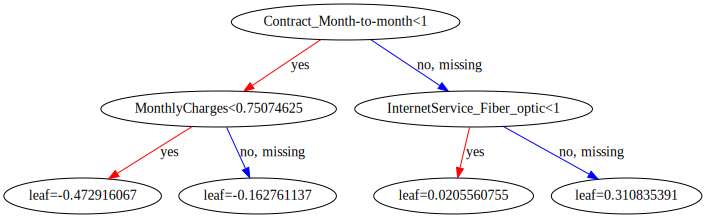

In [53]:
# node_params={'shape':'box','style':'filled, rounded','fillcolor':'#78cbe'}
# leaf_params={'shape':'box','style':'filled','fillcolor':'#e48038'}

# The num_trees param in graphviz is not number of trees to plot. but the specific tree to plot. It is the specific tree to plot
xgb.to_graphviz(clf_xgb,num_trees=0,size='10,10')

## Observations
- Each branch says yes or no or missing. Missing is the default option when there's missing data
- leaves tell us the output ptobability of each leaf

# Comparing other models

I tried to implement other models as well. I implemented Dummy classifier (as baseline), k-nearest neighbors, logistic regression, SVMs, Random Forest and Gradient Boosting

In [54]:
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

def create_models(seed=42):

    models=[]
    models.append(('dummy_classifier',DummyClassifier(random_state=seed,strategy='stratified')))
    # models.append(('k_nearest_neigh',KNeighborsClassifier(n_neighbors=2)))
    models.append(('logistic_regression',LogisticRegression(random_state=seed)))
    models.append(('Support_vector_machines',SVC(random_state=seed)))
    models.append(('random_forest',RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting',GradientBoostingClassifier(random_state=seed)))

    return models

models=create_models()

In [55]:
# Testing accuracy of each model
from sklearn.metrics import accuracy_score
res=[]
names=[]
scoring='accuracy'

for name,model in models:
    # Fitting data and then 
    model.fit(X_train,y_train)
    predictions=model.predict(X_test)
    accuracy=accuracy_score(y_test,predictions)
    res.append(accuracy)
    names.append(name)

    print(f'classifier: {name}, accuracy: {accuracy}')

classifier: dummy_classifier, accuracy: 0.626916524701874
classifier: logistic_regression, accuracy: 0.8006814310051107
classifier: Support_vector_machines, accuracy: 0.7955706984667802
classifier: random_forest, accuracy: 0.7847813742191937
classifier: gradient_boosting, accuracy: 0.7995457126632595


All the above algos have been trained using default params. I tried to perfrom hyperparamter tuning on Logistic Regression since it showed the maximum accuracy

In [56]:
# Tuning logistic regression 

param_grid={'penalty':['l1','l2'],'C':[0.001,0.01,0.5,5,10,20,50,100],'solver':['liblinear']}

Log_reg_params=GridSearchCV(estimator=LogisticRegression(max_iter=200,class_weight='balanced'),param_grid=param_grid,scoring='accuracy',cv=3,n_jobs=-1)
Log_reg_params.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=200),
             n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.5, 5, 10, 20, 50, 100],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='accuracy')

In [57]:
Log_reg_params.best_params_

{'C': 5, 'penalty': 'l1', 'solver': 'liblinear'}

In [58]:
clf_log=LogisticRegression(penalty='l1',C=5,solver='liblinear')
clf_log.fit(X_train,y_train)

LogisticRegression(C=5, penalty='l1', solver='liblinear')

In [59]:
y_log_pred=clf_log.predict(X_test)
log_reg_acc_score=accuracy_score(y_test,y_log_pred)
print(log_reg_acc_score)

0.8086314593980692


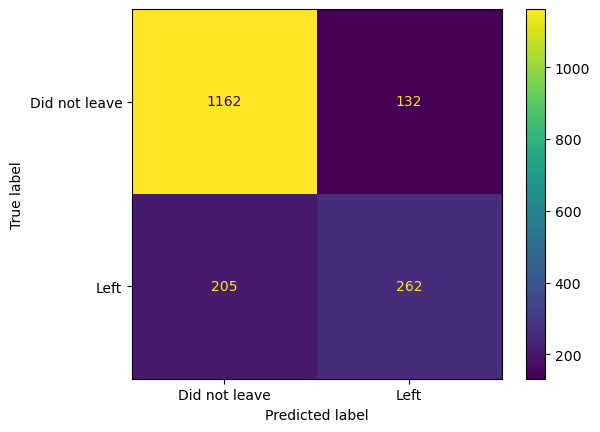

In [60]:
# Confusion matrix for Logistic regression

cm_log=confusion_matrix(y_test,y_log_pred)
disp_log=ConfusionMatrixDisplay(cm_log,display_labels=['Did not leave','Left'])
disp_log.plot()


## Logistic Regression observation
I observed that although Logistic regression gave an accuracy score of 80%. The number of people who left the company were correctly classified better in case of XGBoost. So, which model to use depends on the user requirements and what the user prioritizes.
Also, hyperparameter tuning in logistic regression barely increased the accuracy